<a href="https://colab.research.google.com/github/LucianoPer/VPC2/blob/main/1_Introduccion_Vision_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Redes Neuronales para vision artificial** 

Libros para profundizar temas 

● Computer Vision: Algorithms and Applications, 2nd ed. : https://szeliski.org/Book/, R. Szeliski

● Deep Learning: https://www.deeplearningbook.org/, I. Goodfellow, J. Bengio, A. Courville

● Reinforcement Learning: An Introduction: http://incompleteideas.net/book/the-book-2nd.html, R.
Sutton and A. Barto


##Redes Neuronales convolucionales

Las redes neuronales convolucionales son redes neuronales compuestas por capas 
con ciertas caracteristicas. (capa de convolucion, capa de pooling).

Estas redes estan basadas en la forma que procesan visualmente lo que ven los animales. 

Esta forma de reconocer objetos tiene la caracteristica de invarianza, es decir, reconocer un objeto independientemente de la orientacion, posicion o escala dentro del campo visual. 

Para poder trabajar sin tener problemas computacionales aparece la necesidad de reducir la cantidad de paramentros y ademas con ello disminuir la probabilidad de overfitting. 

##Inspiracion Biologica 

Las imagenes son procesadas en el cerebro por la corteza visual, la cual se encuentra en la parte trasera del cerebro. 

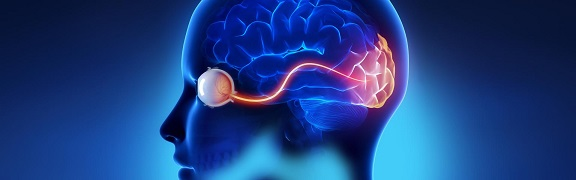

La corteza visual mediante las areas iniciales detecta las caracteristicas simples (features) de la imagen, luego esta informacion es nuevamente procesada por regiones posteriores para obtener caracteristicas mas complejas.
Las neuronas de la corteza v1, codifican orientacion y posicion en el campo visual. Esos puntos espaciales se conocen como receptive fields. 
Un grupo determinado de neuronas responde unicamente a una determinada orientacion espacial dentro de una region y solo se activan al detectar estimulos de este tipo. 

Existen diferentes tipos de neuronas respecto a que son sensibles:
- Center-Surround (diferencia de gaussianas )
- Bordes
- Rectagulos de diferentes formas
- Movimiento
- Color

##Capas de las redes neuronales artificiales

- Capa detectora de bordes
- Capa detectora de partes
- Capa detectora de objetos enteros

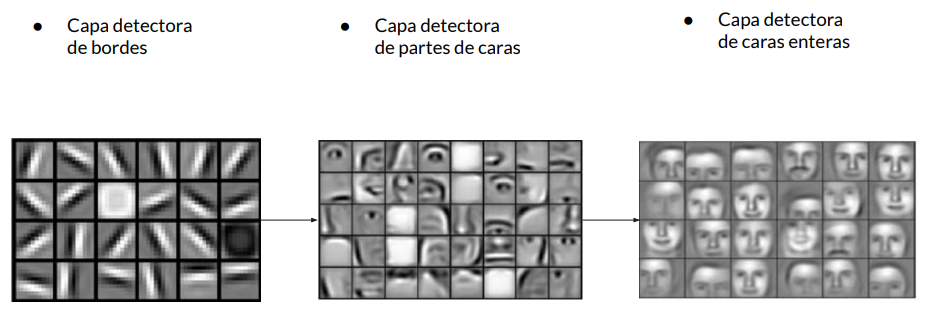

##**Capas Convolucionales** 

Realiza la convolucion entre la imagen y un determinado filtro. Generalmente son varios filtros utilizados para detrectar caracteristicas de la imagen como bordes. 

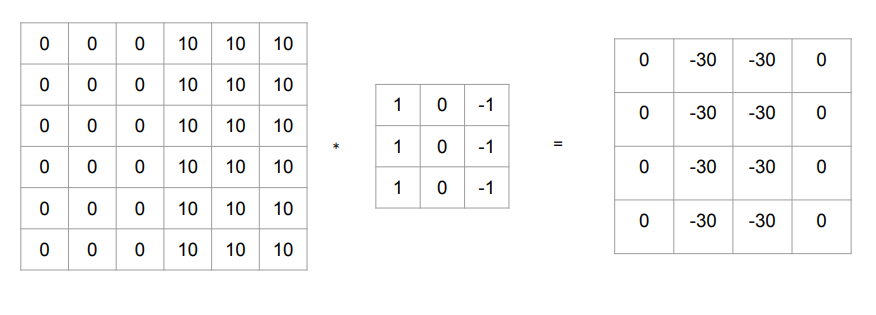

En el caso anterior cada porcion de la imagen es multiplicada por el filtro y el resultado  es sumado  elemento a elemento dando como resultado un unico numero, asi sucesivamente se va saltando por la imagen haciendo la misma operacion. La distancia de salto nos dara una relacion del temano de la imagen de salida. El filtro anterior es para detectar bordes verticales

###Padding 

El Padding consiste en completar los bordes de la imagen con valores que pueden ceros (zero - padding ) de tal forma que al realizar la convolucion el filtro arranque desde el padding y los valores de los bordes sean utilizados mas veces al realizar las operaciones. Esto ayuda tambien a conservar la dimension de la imagen.

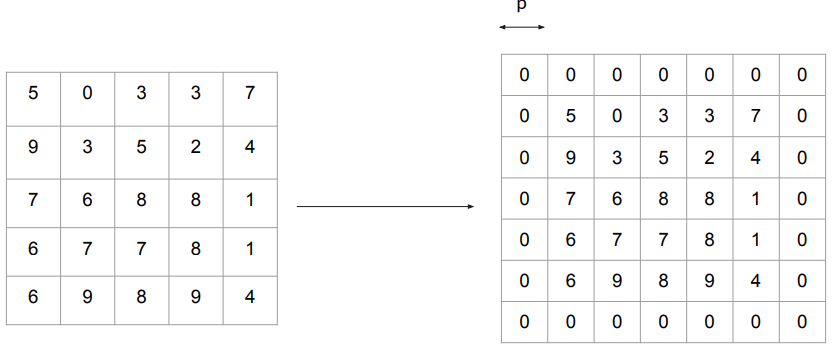

Por lo tanto luego de la convolucion la dimension de la imagen de salida sera :

\begin{equation}
n - f + 2p + 1 = 5 - 3 + 2*1 + 1 = 5 
\end{equation}

Para un filtro de f = 3 con un padding p = 1 la imagen luego de la convolucion conserva su dimension.  

Para la implementacion tenemos dos tipos de paddding en keras, **'valid'** y **'same'**

**valid** -> Sin padding

**same**  -> Agrega padding de tal forma que la imagen de salida conserve las dimensiones de la imagen de entrada antes de la convolucion.
\begin{equation}
p = floor( (f-1)/2 ) 
\end{equation}

###Stride
 ( Zancada ) : la cantidad que salto o desplazo el filtro sobre la imagen original. La zancada determinara el tamano de la salida. 

Por lo tanto el volumen de salida queda resumido a la siguiente formula:

\begin{equation}
n_s =  floor(( (n_e+ 2p-f )/s ) + 1 ) 
\end{equation}

En el siguiente ejemplo vemos una imagen de *nxn=5x5x3* con zero-padding *p=1* y un stride de *s=2*. Dos filtros *W0 y W1* de *fxf=3x3x3*  Cada filtro con sus canales se convolociona con cada canal de la imagen original, por lo que la salida tendra dos canales porque tenemos dos filtros. El tamano de la salida sera:

\begin{equation}
n_s =  floor(( (n_e+ 2p-f )/s ) + 1 ) = Floor(((5 +2*1 - 3)/2)+1) = 3---->[3x3x2]
\end{equation}

Una imagen de 3x3 con 2 canales

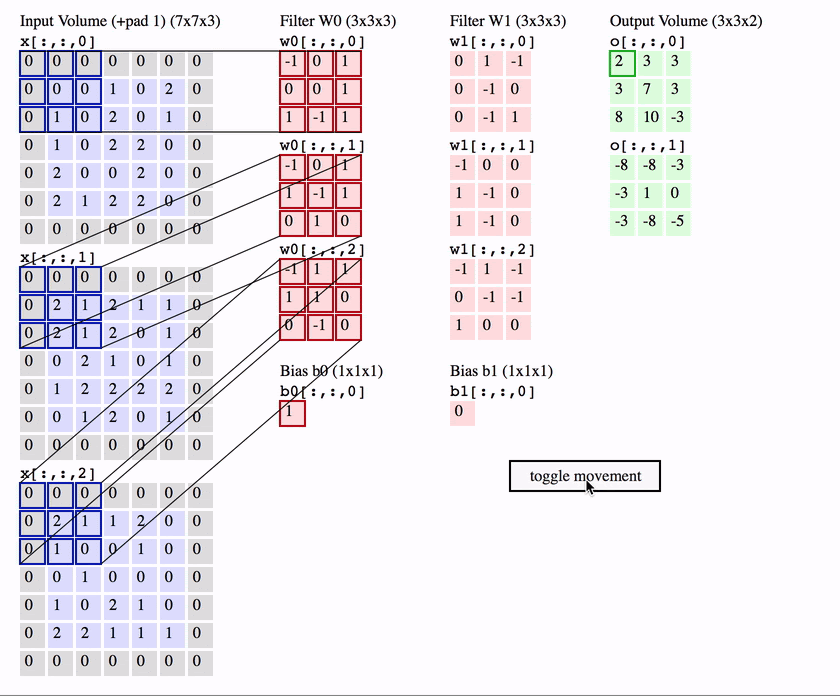 

##**Capas de Pooling** 

Las capaz de pooling se utilizan para reducir la dimension de la imagen de salida. El Pooling puede ser por maximo o por promedio. Es decir, de la imagen original se toma un bloque de tamano fxf y se calcula el promedio o el maximo, luego ese valor sera la salida del bloque fxf.  

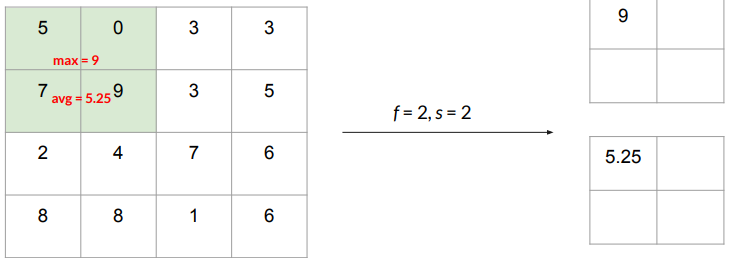

En la capas de pooling tambien tenemos el hiperparametro Stride, el cual indica el salto de las porciones de fxf sobre la imagen. 

La dimension de salida tambien esta dada por la formula :

\begin{equation}
n_s =  floor(( (n_e - f )/s ) + 1 ) 
\end{equation}

Notamos que la formula es la misma que para las capas convolucionales solo que el padding en este caso es cero. 
Para el ejemplo de la imagen la dimension de salida es :
\begin{equation}
n_s =  floor(( (4 - 2 )/2 ) + 1 ) = 2 -----> [2x2x1]
\end{equation}

##Paso forward Capa convolucional y de pooling en numpy (codigo)

Primero vamos a realizar una funcion para agregar zero-padding a un set de valores. Podemos realizarlo de forma manual o utlizando la funcion pad de numpy

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

####**Funcion que agrega padding a una imagen**

In [ ]:
# FUNCION PARA AGREGAR PADDING A UNA IMAGEN 
def zero_pad (X ,pad ):
  # rellena los bordes de la imagen X con ceros 
  # imagen X --> (m,n_H,n_W,n_C) --> m:cantidad de imagenes / n_H: cantidad de pixeles de altura/ n_W: cant. p. de ancho / n_C: Cantidad de canales de cada imagen   
  m, n_H, n_W, n_C = X.shape
  X_pad = np.zeros((m, n_H + 2*pad, n_W + 2*pad, n_C))
  # Recorremos cada imagen de las m imagenes
  for i in range(m):
    # Recorremos cada canal de cada imagen
    for c in range(n_C):
      # debemos dejar 'pad' ceros en los bordes de la imagen X_pad
      X_pad[i , pad:pad+n_H, pad:pad+n_W, c] = X[i, :, :, c]
  return X_pad 


Antes del padding  (4, 3, 3, 2)
Luego del padding  (4, 7, 7, 2)


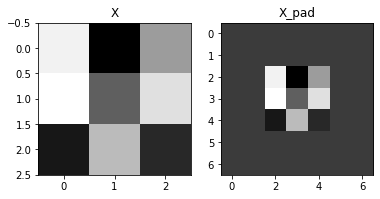

In [ ]:
np.random.seed(1)
# Creamos 4 imagenes aleatorias de 3x3 con dos canales
X = np.random.randn(4,3,3,2)

# Llamamos la funcion X_pad
X_pad = zero_pad(X,2)

print('Antes del padding ',X.shape)
print('Luego del padding ',X_pad.shape)

fig, ax = plt.subplots(1,2)
ax[0].set_title('X')
# mostramos una imagen y un canal 
ax[0].imshow(X[0,:,:,0])
ax[1].set_title('X_pad')
ax[1].imshow(X_pad[0,:,:,0])

####**Funcion para realizar la convolucion**

In [ ]:
# FUNCION QUE REALIZA UN PASO DE CONVOLUCION (porcion de imagen del tamano del filtro de convolucion) 
# a_slice_prev es la activacion de la capa anterior (salida)
# W es el filtro para la convolucion
# b es el bias que se sumara al resultado de la convolucion 
def conv_single_step(a_slice_prev, W, b):
  # realizamos la multiplicacion elemento a elemento de la porcion de imagen a 
  s = a_slice_prev * W 
  # luego debemos sumar los elementos 
  Z = np.sum(s)
  # Z es un numero resultado de mult. elemento a elemnto y sumar. Se le suma el bias
  Z = Z + b
  return Z 

In [ ]:
np.random.seed(1)
# W filtro de 4x4 con 3 canales
W = np.random.randn(4,4,3)
# a_slice_prev es una porcion de imagen de 4x4 x 3 canales
a_slice_prev = np.random.randn(4,4,3)
# bias es un numero 
b = np.random.randn(1,1,1)


# llamamos a la funcion para relaizar el paso de convolucion
Z = conv_single_step(a_slice_prev, W, b)
print('Z = ',Z)

Z =  [[[-6.99908945]]]


Vamos a calcular la convolucion del paso forward de m imagenes de n_c canales. La funcion recibe ademas un diccionario que contienen los hiperparametros (stride, pad)

In [ ]:
# FUNCION QUE CALCULA LA CONVOLUCION DEL PASO FORWARD DE m IMAGENES DE n_C_prev CANALES CON FILTROS W DE fxf y   n_C CANALES 
def conv_forward(A_prev, W, b, hparam):
  # A_prev --> activacion de la capa anterior --> ( m , n_H_prev, n_W_prev, n_C_prev )
  # W --> filtros (f, f , n_C_prev, n_C) 
  # b --> bias de (1, 1 ,1 ,n_C)
  # Z --> Salida ( m , n_H , n_W , n_C)


  # dimensiones de la imagen de entrada (activacion capa previa)
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  # las dimensiones del filtro
  (f, f, n_C_prev, n_C) = W.shape
  # Hiperparametros
  stride = hparam['stride']
  pad = hparam['pad']

  # Calculamos las dimensiones que tendra la imagen de salida 
  n_H = int((n_H_prev + 2*pad - f)/stride) + 1
  n_W = int((n_W_prev + 2*pad - f)/stride) + 1

  # inicializamos la salida con ceros 
  Z = np.zeros((m,n_H,n_W,n_C))

  # Agregamos el padding a la activacion previa antes de realizar la convolucion
  # llamamos a la funcion que creamos anteriormente para agregar paddding
  A_prev_pad = zero_pad(A_prev , pad)

  # Iteramos entre las m imagenes de entrada
  for i in range(m):
    # Seleccionamos la i-esima imagen
    A_prev_pad_i = A_prev_pad[i,:,:,:]
    # recorremos los pixeles verticales y definimos el slice
    for h in range(n_H): 
      vert_start = h*stride
      vert_end = vert_start + f
      # recorremos los pixeles horizontales y definimos el slice
      for w in range(n_W):
        horiz_start = w*stride 
        horiz_end = horiz_start + f
        # recorremos uno a uno la cantidad de filtros
        for c in range(n_C):
          # seleccionamos el slice de la imagen para realizar la multiplicacion con el filtro
          a_slice_prev = A_prev_pad_i[vert_start:vert_end,horiz_start:horiz_end,:]
          # seleccionamos el filtro c el cual tiene la misma cantidad  de canales que la imagen
          weights = W[:,:,:,c]
          biases = b[:,:,:,c]
          # llamamos a la funcion que realiza la convolucion del filtro con el bloque de la imagen en los n canales --> nos da un numero 
          Z[i,h,w,c] = conv_single_step(a_slice_prev,weights,biases)
 
  assert(Z.shape == (m,n_H,n_W,n_C))

  cache = (A_prev, W, b, hparam)
  return Z,cache


In [ ]:
# Generamos numeros 
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,"stride": 2}

In [ ]:
# llamamos a la funcion que realiza la convolucion de las imagenes con los filtros
Z, cache_connv  = conv_forward(A_prev,W,b,hparameters)

# Las dimensiones de la imagen de salida seran 
#hn = (h + 2p - f /s) + 1 =  3  
#wn = (w + 2p - f /s) + 1 =  4
# m = 10 imagenes // tantos canales como filtros n_C = 8  

In [ ]:
Z.shape

(10, 3, 4, 8)

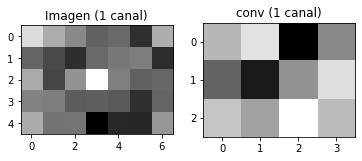

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Imagen (1 canal)')
# mostramos una imagen y un canal 
ax[0].imshow(A_prev[0,:,:,0])
ax[1].set_title('conv (1 canal)')
ax[1].imshow(Z[0,:,:,0])

In [ ]:
print(Z.mean())

0.6923608807576933


####**Funcion para realizar el Pooling**

La capa de pooling reduce la altura y el ancho de la entrada, a fin de reducir los costos de computo y logra que los detectores de features sean mas invariantes a su posicion dentro de la entrada. Existen dos tipos de pooling:

**Max-pooling**  desplaza una ventana fxf sobre la entrada y guarda el valor maximo dentro de esa ventana

**Average-pooling** Desplaza una ventana fxf y guarda el promedio

In [ ]:
def pool_forward( A_prev, hparam, mode="max" ):
  # Dimensiones de la entrada
  (m ,n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  f = hparam["f"]
  stride = hparam["stride"]

  # La salida tendra dimensiones 
  n_H = int((n_H_prev - f)/stride) + 1
  n_W = int((n_W_prev - f)/stride) + 1
  n_C = n_C_prev

  # inicializamos la imagen de salida
  A = np.zeros((m, n_H, n_W, n_C))

  # Reconrremos las m imagenes
  for i in range(m):
    # Recorremos los pixeles horizontales de la imagen de salida 
    for h in range(n_H):
      # calculamos los indices para el slice
      vert_start =  h*stride
      vert_end = vert_start + f

      #Recorremos los pixeles verticales 
      for w in range(n_W):
        horiz_start = w*stride
        horiz_end = horiz_start + f

        # Recorremos los canales de la imagen
        for c in range(n_C):
          # seleccionamos un canal de la imagen y el slice 
          a_prev_silce = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

          # obtenemos el modo pasado como parametro
          if mode == "max":
            # la salida en esa posicion de n_h n_W en esa imagen y canal es 
            A[i,h,w,c] = a_prev_silce.max()
          elif mode =="average":
            A[i,h,w,c] = a_prev_silce.mean()

  # Guardamos la entrada y los hparametros en cache 
  cache = (A_prev, hparam)

  # Verificamos que las dimensiones sean las correctas
  assert(A.shape == (m, n_H,n_W , n_C))

  return A, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 6, 6, 3)
hparameters = {"stride" : 2, "f": 2}

A, cache = pool_forward(A_prev, hparameters)

In [ ]:
# las dimensiones de salida para una imagen de 5x5 con f=3 y stride=1
# hn = h - f /stride + 1 = 3
# wn = w - f /stride + 1 = 3

# la cantidad de imagenes es la misma y la cantidad de canales no cambia
A.shape

(2, 3, 3, 3)

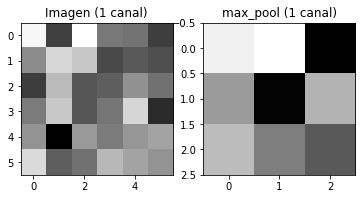

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Imagen (1 canal)')
# mostramos una imagen y un canal 
ax[0].imshow(A_prev[0,:,:,0])
ax[1].set_title('max_pool (1 canal)')
ax[1].imshow(A[0,:,:,0])